## Atempt to write optimal search algorithm for Rottnest Swim using ROMS 3D currents

In [1]:
import heapq
import numpy as np
import scipy.interpolate
import xarray as xr

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def distance(lat1, lon1, lat2, lon2):
    # http://www.movable-type.co.uk/scripts/latlong.html
    R = 6.371e6
    lat1 *= np.pi/180.
    lon1 *= np.pi/180.
    lat2 *= np.pi/180.
    lon2 *= np.pi/180.
    return R*np.arccos(
        np.sin(lat1)*np.sin(lat2) + 
        np.cos(lat1)*np.cos(lat2)*np.cos(lon2-lon1))

In [4]:
def bearing(lat1, lon1, lat2, lon2):
    # http://www.movable-type.co.uk/scripts/latlong.html
    lat1 *= np.pi/180.
    lon1 *= np.pi/180.
    lat2 *= np.pi/180.
    lon2 *= np.pi/180.
    y = np.sin(lon2-lon1)*np.cos(lat2)
    x = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(lon2-lon1)
    return np.arctan2(y, x)

In [5]:
def get_roms_point(lon, lat, lon_p, lat_p):
    lon = lon[:]
    lat = lat[:]
    d=(lat-lat_p)**2+(lon-lon_p)**2
    ny, nx = np.unravel_index(np.argmin(d),d.shape)
    return ny, nx

In [6]:
def roms_bbox(roms, location):
    # location = [115.47, 115.767, -32.08, -31.93]
    # roms is Xarray object with longitude, latitude
    xi = np.empty(4)
    yi = np.empty(4)
    yi[0],xi[0] = get_roms_point(roms.longitude.values, roms.latitude.values, location[0], location[2])
    yi[1],xi[1] = get_roms_point(roms.longitude.values, roms.latitude.values, location[0], location[3])
    yi[2],xi[2] = get_roms_point(roms.longitude.values, roms.latitude.values, location[1], location[2])
    yi[3],xi[3] = get_roms_point(roms.longitude.values, roms.latitude.values, location[1], location[3])
    bbox = [min(xi),max(xi),min(yi),max(yi)]
    return bbox

In [7]:
def compute_graph(x,y):
    G = {}
    for i in range(len(x)):
        for j in range(len(y)):
            G[j, i] = []
            if i > 0:
                if j > 0:
                    G[j, i].append((j-1, i-1))
                if j+1 < len(y):
                    G[j, i].append((j+1, i-1))
                G[j, i].append((j, i-1))
            if i+1 < len(x):
                if j > 0:
                    G[j, i].append((j-1, i+1))
                if j+1 < len(y):
                    G[j, i].append((j+1, i+1))
                G[j, i].append((j, i+1))
            if j > 0:
                G[j, i].append((j-1, i))
            if j+1 < len(y):
                G[j, i].append((j+1, i))
    return G

In [8]:
def calculate_cost(X, Y, mask, U, V, T, t, v1, v2, s0):
    l = (T <= t).nonzero()[0].max()
    j1, i1 = v1
    j2, i2 = v2

    u = (U[l,j1,i1] + U[l,j2,i2])/2.
    v = (V[l,j1,i1] + V[l,j2,i2])/2.
    
    ds = distance(Y[v1], X[v1], Y[v2], X[v2])
    a = bearing(Y[v1], X[v1], Y[v2], X[v2])
    
    # ocean_velocity_bearing: 0.5*np.pi - np.atan(v,u) 
    # ocean_velocity_speed = np.sqrt(u**2+v**2)
    # ocean_velocity and swim track relative_angle: bearing - velocity_bearing
    # ocean currtent along the swim track component: velocity_speed * np.cos(relative_angle)
    # ocean currtent perpendicular to swim track: velocity_speed * np.sin(relative_angle)
    # velocity along track helps or not (depending on direction)
    # velocity perpendicular must be compensated using swim speed s0 to get to the target point (!)

    rel_angle = a - (0.5*np.pi - np.arctan2(v,u))
    oa = np.sqrt(u**2 + v**2) * np.cos(rel_angle)
    op = np.abs(np.sqrt(u**2 + v**2) * np.sin(rel_angle))
    s = s0 + oa - op
    
    # not beaching, prevent path on the land using mask
    if np.logical_or(mask[v1]<0.9, mask[v2]<0.9):
        s = -1
    if s < 0:
        return np.inf
    else:
        # print("%.2f %.2f %.2f %d" %(s, oa, op, ds/s))
        return ds/s

In [9]:
def shortest_path(X, Y, mask, U, V, T, G, start, end, s0=0, t0=0):
    q = [(t0, start, ())]
    visited = {}
    while 1:
        cost, v1, path = heapq.heappop(q)
        if v1 not in visited or visited[v1] > cost:
            path = path + (v1,)
            visited[v1] = cost
            if v1 == end:
                return cost, list(path)
            for v2 in G[v1]:
                cost2 = calculate_cost(X, Y, mask, U, V, T, cost, v1, v2, s0)
                if (v2 not in visited or visited[v2] > cost2) and cost+cost2 <= T[-1]:
                    heapq.heappush(q, (cost+cost2, v2, path))

In [10]:
# download ROMS currents
!rm -f /tmp/perth_ocean.nc
!wget 'http://myocean.mywire.org/Sailing/perth_ocean.nc' -O /tmp/perth_ocean.nc

--2023-02-03 15:39:07--  http://myocean.mywire.org/Sailing/perth_ocean.nc
Resolving myocean.mywire.org (myocean.mywire.org)... 146.118.65.212
Connecting to myocean.mywire.org (myocean.mywire.org)|146.118.65.212|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19316591 (18M) [application/x-netcdf]
Saving to: '/tmp/perth_ocean.nc’

/tmp/perth_ocean.nc 100%[===================>]  18.42M   102MB/s    in 0.2s    

2023-02-03 15:39:07 (102 MB/s) - '/tmp/perth_ocean.nc’ saved [19316591/19316591]



In [12]:
roms = xr.open_dataset('/tmp/perth_ocean.nc')

In [13]:
roms

<xarray.Dataset>
Dimensions:    (time: 120, j: 259, i: 129)
Coordinates:
  * time       (time) datetime64[ns] 2023-02-03 ... 2023-02-07T23:00:00
    longitude  (j, i) float64 ...
    latitude   (j, i) float64 ...
Dimensions without coordinates: j, i
Data variables:
    mask       (j, i) int8 ...
    u          (time, j, i) float32 ...
    v          (time, j, i) float32 ...
Attributes:
    title:        Ocean surface currents for Central Western Australia
    description:  Ocean model domain at 2 km (cwa) and Perth domain at 500 m ...
    author:       Ocean ROMS model setup and run by Ivica Janekovic ivica.jan...
    type:         netCDF

In [14]:
# ROMS time in secs from the start
T = (roms.time.values - roms.time[0].values).astype(int)/1e9

In [15]:
bbox = roms_bbox(roms, [115.47, 115.767, -32.08, -31.93])
bbox = np.array(bbox).astype('int')
bbox

array([ 45, 106, 127, 160])

In [16]:
# subset ROMS currents for the bbox
U = roms.u.isel(i = range(bbox[0],bbox[1]+1), j = range(bbox[2],bbox[3]+1)).values
V = roms.v.isel(i = range(bbox[0],bbox[1]+1), j = range(bbox[2],bbox[3]+1)).values
# zero missing values on the land 
U[np.isnan(U)] = 0.0
V[np.isnan(V)] = 0.0

In [17]:
# subset coordinate locations 
lon =   roms.longitude.isel(i = range(bbox[0],bbox[1]+1), j = range(bbox[2],bbox[3]+1)).values
lat =   roms.latitude.isel(i = range(bbox[0],bbox[1]+1), j = range(bbox[2],bbox[3]+1)).values
mask = roms.mask.isel(i = range(bbox[0],bbox[1]+1), j = range(bbox[2],bbox[3]+1)).values

In [41]:
# define start and end locations
start = get_roms_point(lon, lat, 115.749532, -31.994491)
end   = get_roms_point(lon, lat, 115.543515, -31.996739)
# or just use guess 
start = (19,57)
end = (21,15)
start, end

((19, 57), (21, 15))

In [19]:
roms.close()

### Regrid on the 5x finer grid, just for fun

In [20]:
# regrid ROMS data onto finer resolution (i.e. 100m which is 5 times original) 
xf = np.linspace(lon[0,0], lon[0,-1], np.shape(lon)[1]*5)
yf = np.linspace(lat[0,0], lat[-1,0], np.shape(lat)[0]*5)
np.shape(xf), np.shape(yf)

((310,), (170,))

In [21]:
from scipy.interpolate import griddata
imethod = 'linear'
Xf, Yf = np.meshgrid(xf, yf)
Uf = np.empty([len(T), np.shape(Xf)[0], np.shape(Yf)[1]])
Vf = np.empty([len(T), np.shape(Xf)[0], np.shape(Yf)[1]])
maskf = np.empty([np.shape(Xf)[0], np.shape(Yf)[1]])
maskf = griddata(np.c_[lon.flatten(), lat.flatten()], mask.flatten(), (Xf, Yf), method = imethod)
for t in range(0, len(T)):
    Uf[t,:,:]= griddata(np.c_[lon.flatten(), lat.flatten()], U[t,:,:].flatten(), (Xf, Yf), method = imethod)
    Vf[t,:,:]= griddata(np.c_[lon.flatten(), lat.flatten()], V[t,:,:].flatten(), (Xf, Yf), method = imethod)

In [22]:
startf = get_roms_point(Xf, Yf, 115.749532, -31.99)
endf = get_roms_point(Xf, Yf, 115.543515, -31.99)

In [49]:
# use the same coords as in native grid solution
startf = get_roms_point(Xf, Yf, lon[start], lat[start])
endf = get_roms_point(Xf, Yf, lon[end], lat[end])

In [50]:
print(np.shape(maskf), startf, endf)

(170, 310) (97, 289) (108, 76)


In [51]:
maskf[startf], maskf[endf]

(0.948220064725014, 1.0)

In [52]:
startf = (97,288)  # move a bit to make sure they are in the ocean
maskf[startf], maskf[endf]

(1.0, 1.0)

## Define search algorithm stuff on the fine grid

In [26]:
Gf = compute_graph(xf,yf)

In [27]:
# test for semi-idealised case
Vf_zero = Vf.copy()
Uf_zero = Uf.copy()
Uf_zero[:,:,150::] = 0
Vf_zero[:,:,150::] = 0

## Define search algorithm stuff on the native grid

In [28]:
x = lon[0,:]
y = lat[:,0]
X, Y = np.meshgrid(x, y)

In [29]:
G = compute_graph(x,y)

In [30]:
# test for semi-idealised case
V_zero = V.copy()
U_zero = U.copy()
U_zero[:,:,30::] = 0
V_zero[:,:,30::] = 0

## Run the model on the fine grid

In [53]:
%%time
end_timef, optimal_pathf = shortest_path(Xf, Yf, maskf, Uf, Vf, T, Gf, startf, endf, 0.667, T[0])

CPU times: user 15.4 s, sys: 24.6 ms, total: 15.4 s
Wall time: 15.4 s


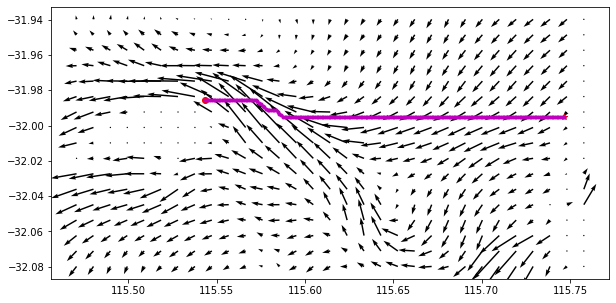

In [54]:
plt.figure(figsize = (10, 5))
rec = 4;
q = plt.quiver(Xf[0:-1:10,0:-1:10],Yf[0:-1:10,0:-1:10],Uf[rec, 0:-1:10,0:-1:10],Vf[rec, 0:-1:10,0:-1:10])
plt.plot(Xf[startf],Yf[startf],'r*')
plt.plot(Xf[endf],Yf[endf],'ro')

for i in range(0,np.shape(optimal_pathf)[0]):
    plt.plot(Xf[optimal_pathf[i]], Yf[optimal_pathf[i]], 'm.')

## Run the model on the native grid

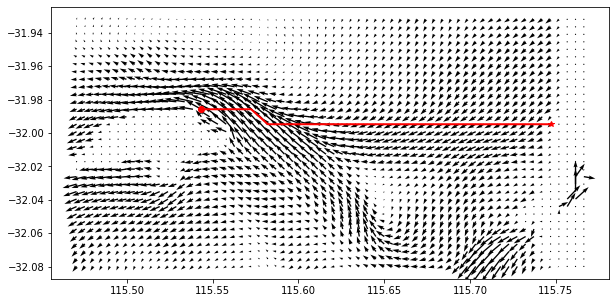

In [55]:
end_time, optimal_path = shortest_path(X, Y, mask, U, V, T, G, start, end, 0.667, T[0])
plt.figure(figsize = (10, 5))
plt.title("")
rec = 4;
q = plt.quiver(x, y, U[rec,:,:], V[rec,:,:], color = 'k')
plt.plot(X[start],Y[start],'r*')
plt.plot(X[end],Y[end],'ro')
xx = []
yy = []
for i in range(0,np.shape(optimal_path)[0]):
    xx.append(X[optimal_path[i]])
    yy.append(Y[optimal_path[i]])
    
plt.plot(xx,yy,'r',linewidth=2);


In [56]:
end_time/3600, end_timef/3600

(7.04547868787257, 7.00738211127372)

In [35]:
# fastest swimmers go with 1.389 and slowest 0.667 m/s 
1000/(12*60), 1000/(25*60)

(1.3888888888888888, 0.6666666666666666)